Should generate all_results.json by running evaler.py first.

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.ticker import PercentFormatter

# --- 你可以按需要修改的参数 ---
json_path = r"D:\Projects\Gus Xia\S3Plus\LM_align\exp\2025.9.05_10codes\eval_results.json"
save_path_val = None  # 比如 r"D:\tmp\val_label_acc_bar.png"
save_path_ood = None  # 比如 r"D:\tmp\ood_label_acc_bar.png"

# 展示标签（x轴）与 JSON 中的真实 key 的配对（1~10）
# 这里统一用字符串key对齐你json中的 "1.0"..."10.0"
label_key_map = OrderedDict([
    ("one",   "1.0"),
    ("two",   "2.0"),
    ("three", "3.0"),
    ("four",  "4.0"),
    ("five",  "5.0"),
    ("six",   "6.0"),
    ("seven", "7.0"),
    ("eight", "8.0"),
    ("nine",  "9.0"),
    ("ten",   "10.0"),
])

# ========== 工具函数 ==========
def collect_stats_for_field(data: dict, field: str, label_key_map: OrderedDict):
    """
    针对 data[field]（如 'val_label_acc' 或 'ood_label_acc'），
    对每个 label(1..10) 聚合所有 exp 的准确率，返回 mean 和 std。
    """
    field_dict = data.get(field, {})
    means, stds = [], []
    for disp_label, json_key in label_key_map.items():
        vals = []
        for exp_name, per_label_dict in field_dict.items():
            if json_key in per_label_dict:
                vals.append(float(per_label_dict[json_key]))
        if len(vals) == 0:
            means.append(0.0)
            stds.append(0.0)
        else:
            arr = np.asarray(vals, dtype=float)
            means.append(float(arr.mean()))
            stds.append(float(arr.std(ddof=0)))
    return means, stds

def plot_bar_with_error(display_labels, means, stds, title, save_path=None):
    x = np.arange(len(display_labels))
    fig, ax = plt.subplots(figsize=(12, 4.8), constrained_layout=True)

    # 柱 + 误差棒（cap）
    bars = ax.bar(x, means, yerr=stds, capsize=6, linewidth=1.2, error_kw={"elinewidth":1.2})
    ax.set_xticks(x)
    ax.set_xticklabels(display_labels)
    ax.set_ylim(0, 1.05)  # 顶部适当留白
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    ax.set_ylabel("Accuracy")
    ax.set_title(title)

    # 轻网格 + 去除上/右边框
    ax.grid(axis='y', linestyle='--', alpha=0.35)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    # 在柱“内或外”放数值：高柱放里，矮柱放顶上
    for rect, m, s in zip(bars, means, stds):
        h = rect.get_height()
        xmid = rect.get_x() + rect.get_width()/2
        label = f"{m*100:.1f}% ± {s*100:.1f}%"
        if h >= 0.82:  # 高柱：放内部，白底图可读性更好
            ax.text(xmid, h - 0.04, label, ha="center", va="top", fontsize=9)
        else:          # 矮柱：放柱顶上方一点
            ax.text(xmid, h + 0.02, label, ha="center", va="bottom", fontsize=9)

    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)




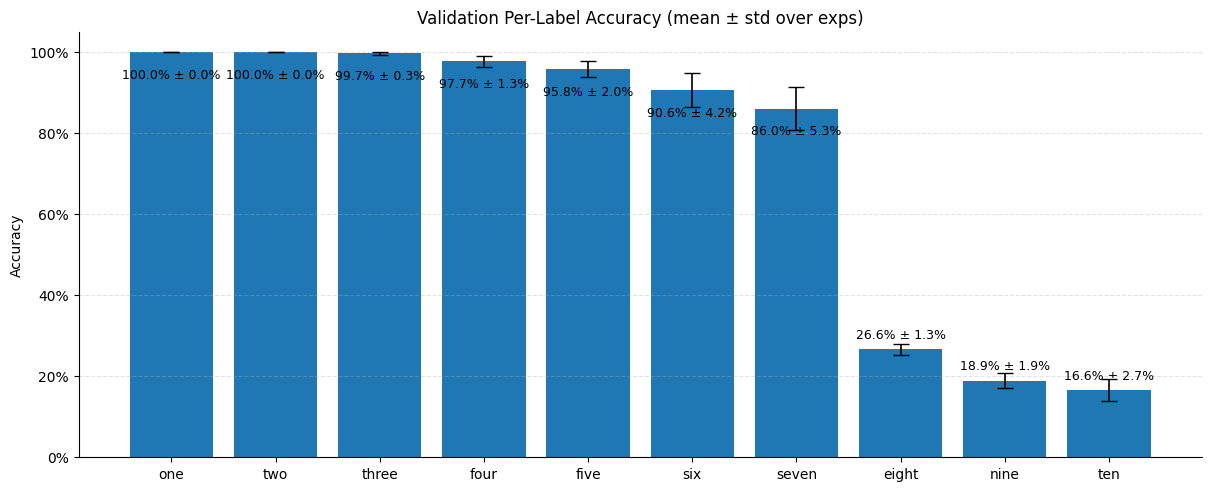

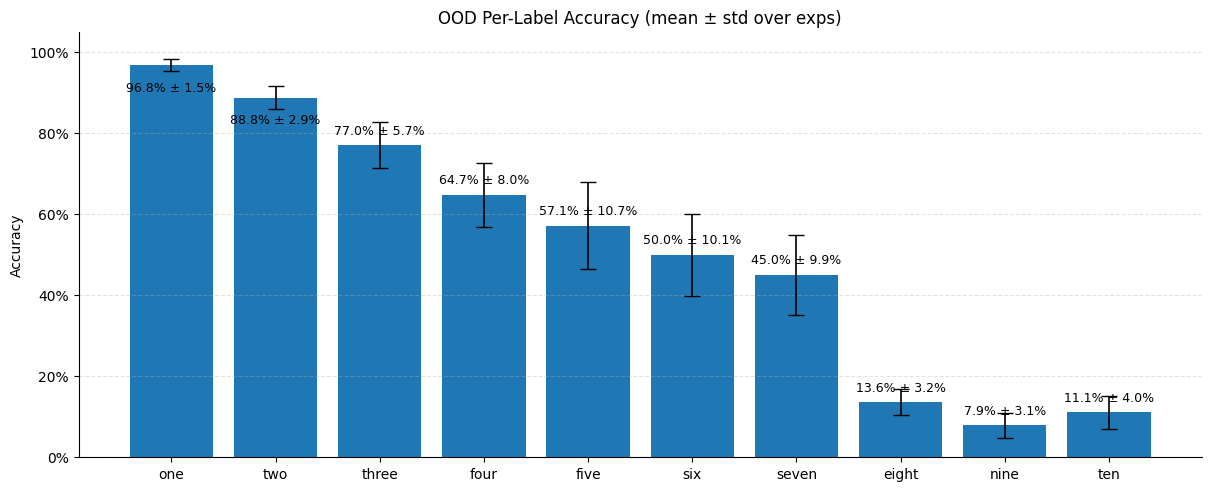

In [4]:
# ========== 主流程 ==========
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

display_labels = list(label_key_map.keys())

# 1) val_label_acc
val_means, val_stds = collect_stats_for_field(data, "val_label_acc", label_key_map)
plot_bar_with_error(display_labels, val_means, val_stds,
                    title="Validation Per-Label Accuracy (mean ± std over exps)",
                    save_path=save_path_val)

# 2) ood_label_acc
ood_means, ood_stds = collect_stats_for_field(data, "ood_label_acc", label_key_map)
plot_bar_with_error(display_labels, ood_means, ood_stds,
                    title="OOD Per-Label Accuracy (mean ± std over exps)",
                    save_path=save_path_ood)

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.ticker import PercentFormatter

# 数字→展示文本 与 JSON里实际key 的映射
LABEL_KEY_MAP = OrderedDict([
    ("one",   "1.0"),
    ("two",   "2.0"),
    ("three", "3.0"),
    ("four",  "4.0"),
    ("five",  "5.0"),
    ("six",   "6.0"),
    ("seven", "7.0"),
    ("eight", "8.0"),
    ("nine",  "9.0"),
    ("ten",   "10.0"),
])

def _collect_means_stds(data: dict, field: str, label_key_map=LABEL_KEY_MAP):
    """对 data[field]（如 'val_label_acc' 或 'ood_label_acc'），
       按 label 聚合所有 exp 的均值与标准差。"""
    field_dict = data.get(field, {})
    means, stds = [], []
    for _, json_key in label_key_map.items():
        vals = [float(per_label_dict[json_key])
                for _, per_label_dict in field_dict.items()
                if json_key in per_label_dict]
        if len(vals) == 0:
            means.append(0.0); stds.append(0.0)
        else:
            arr = np.asarray(vals, dtype=float)
            means.append(float(arr.mean()))
            stds.append(float(arr.std(ddof=0)))
    return np.array(means), np.array(stds)

def plot_grouped_val_vs_ood(json_path: str,
                            save_path: str | None = None,
                            title: str = "Per-Label Accuracy (Val icons vs. OOD icons, mean ± std)"):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    disp_labels = list(LABEL_KEY_MAP.keys())
    val_mean, val_std = _collect_means_stds(data, "val_label_acc")
    ood_mean, ood_std = _collect_means_stds(data, "ood_label_acc")

    x = np.arange(len(disp_labels))
    width = 0.38

    fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
    b1 = ax.bar(x - width/2, val_mean, width,
                yerr=val_std, capsize=6, linewidth=1.2, error_kw={"elinewidth":1.2}, label="Val icons")
    b2 = ax.bar(x + width/2, ood_mean, width,
                yerr=ood_std, capsize=6, linewidth=1.2, error_kw={"elinewidth":1.2}, label="OOD icons")

    ax.set_xticks(x); ax.set_xticklabels(disp_labels)
    ax.set_ylim(0, 1.05)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.35)
    for spine in ("top", "right"): ax.spines[spine].set_visible(False)
    ax.legend(frameon=False)

    # 在 OOD 柱顶标注（也可把 b2 换成 b1 或二者都标）
    # for rect, m, s in zip(b2, ood_mean, ood_std):
    #     xmid = rect.get_x() + rect.get_width()/2
    #     ax.text(xmid, rect.get_height() + 0.02,
    #             f"{m*100:.1f}% ± {s*100:.1f}%", ha="center", va="bottom", fontsize=9)

    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close(fig)
    else:
        plt.show(); plt.close(fig)

# 使用示例：
# 


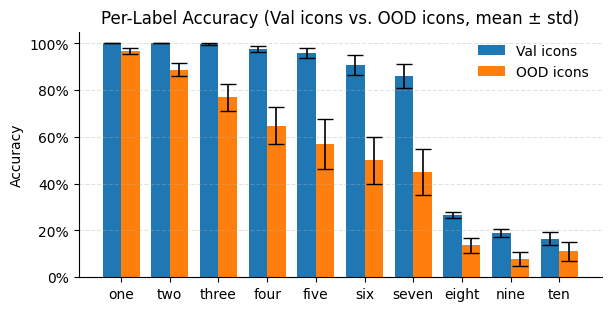

In [13]:
plot_grouped_val_vs_ood(r"D:\Projects\Gus Xia\S3Plus\LM_align\exp\2025.9.05_10codes\eval_results.json")